In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

In [ ]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_P18 = ['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_AC  = ['P26', 'P20', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_TC  = ['P19', 'P22', 'P23',]
chen_patient_order_by_MSI_intensity_SC  = ['P18', 'P17', 'P15']

In [3]:
adata_chen = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')

In [5]:
dict_Identifier_to_lvl_1_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl1.pickle')

dict_Identifier_to_lvl_2_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl2.pickle')

dict_Identifier_to_lvl_1_CellType_Total,  dict_Identifier_to_lvl_2_CellType_Total = dict(), dict()

for k,v in dict_Identifier_to_lvl_1_CellType_1.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_2.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_3.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v

for k,v in dict_Identifier_to_lvl_2_CellType_1.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_2.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_3.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v

In [6]:
temp = list()
for tup in adata_chen.obs.itertuples():
    if tup.Manual_CellType_lvl_1 == 'N/A':
        temp.append( dict_Identifier_to_lvl_1_CellType_Total[tup.Identifier] )
    else:
        temp.append( tup.Manual_CellType_lvl_1 )

adata_chen.obs['Manual_CellType_lvl_1'] = temp

temp = list()
for tup in adata_chen.obs.itertuples():
    if tup.Manual_CellType_lvl_1 == 'Tumor epithelial':
        temp.append( tup.Manual_CellType_lvl_1 )
    else:
        temp.append( dict_Identifier_to_lvl_2_CellType_Total[tup.Identifier] )

adata_chen.obs['Manual_CellType_lvl_2'] = temp

## TME Cell Type proportion (without Epithelials)

In [196]:
CellTypeProportion = list()

for PatientID, edf in adata_chen.obs.groupby('PatientID', observed=False):
    for BiopsySite, edf2 in edf.groupby('BiopsySite', observed=False):
        TotalCount = len(edf2[~(edf2['Manual_CellType_lvl_1'].isin(['Tumor epithelial', 'Normal epithelial']))])
        for Manual_CellType_lvl_1, edf3 in edf2.groupby('Manual_CellType_lvl_1', observed=False):
            if Manual_CellType_lvl_1 in ['Tumor epithelial', 'Normal epithelial',]: continue
            CellTypeProportion.append( [PatientID, BiopsySite, Manual_CellType_lvl_1, len(edf3), len(edf3)/TotalCount] )
            
CellTypeProportion = pd.DataFrame(CellTypeProportion, columns=['PatientID', 'BiopsySite', 'Manual_CellType_lvl_1', 'CellCount', 'CellProportion'])

<Axes: xlabel='Manual_CellType_lvl_1', ylabel='PatientID'>

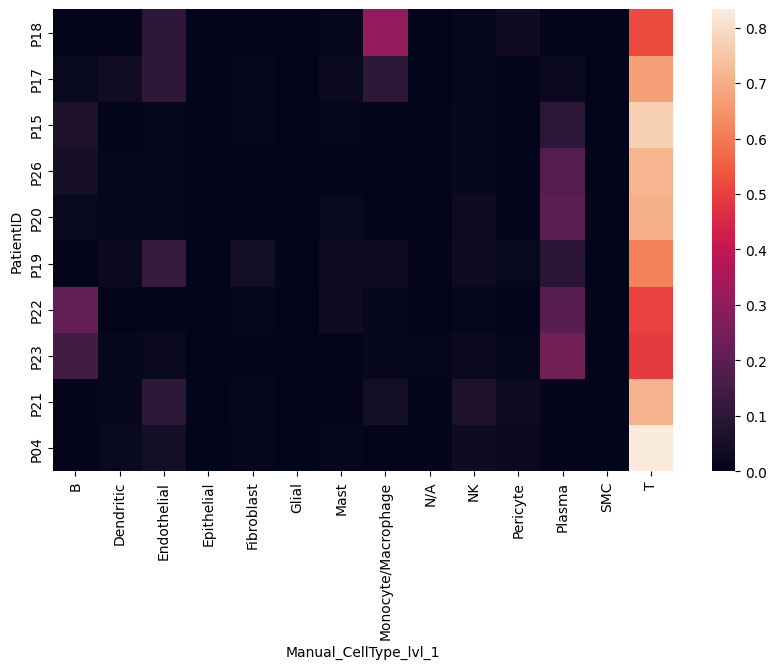

In [165]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))
sns.heatmap(CellTypeProportion[(CellTypeProportion['BiopsySite']=='Tumor')].pivot( index='PatientID', 
                                                                                  columns='Manual_CellType_lvl_1', 
                                                                                  values='CellProportion' ).reindex(chen_patient_order_by_MSI_intensity))

In [198]:
pivot_df = CellTypeProportion[(CellTypeProportion['BiopsySite']=='Tumor')].pivot_table(
    index='PatientID', 
    columns='Manual_CellType_lvl_1', 
    values='CellProportion', 
    aggfunc='sum'
)

# pivot_df = pivot_df.reindex(chen_patient_order_by_MSI_intensity_AC)

pivot_df = pivot_df.reindex(['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P04'])


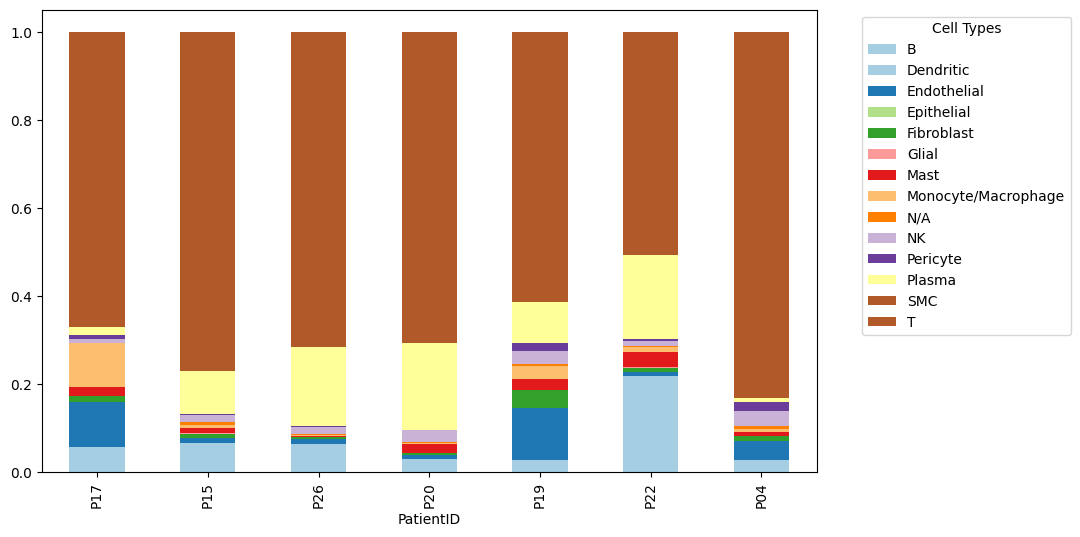

In [199]:
# Plot
pivot_df.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    colormap='Paired', 
    legend=True, 
)

# Move legend to the right side
plt.legend(
    title='Cell Types', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left'
)

In [191]:
CellTypeProportion = list()

for PatientID, edf in adata_chen[~(adata_chen.obs['Manual_CellType_lvl_1'].isin(['Tumor epithelial', 'Normal epithelial', 'N/A', 'Epithelial']))].obs.groupby('PatientID', observed=False):
    for BiopsySite, edf2 in edf.groupby('BiopsySite', observed=False):
        for Manual_CellType_lvl_2, edf3 in edf2.groupby('Manual_CellType_lvl_2', observed=False):
            if Manual_CellType_lvl_2 in ['Tumor epithelial', 'Normal epithelial']: continue
            CellTypeProportion.append( [PatientID, BiopsySite, Manual_CellType_lvl_2, len(edf3), len(edf3)/len(edf2)] )
            
CellTypeProportion = pd.DataFrame(CellTypeProportion, columns=['PatientID', 'BiopsySite', 'Manual_CellType_lvl_2', 'CellCount', 'CellProportion'])

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))
sns.heatmap(CellTypeProportion[(CellTypeProportion['BiopsySite']=='Tumor')].pivot( index='PatientID', 
                                                                                  columns='Manual_CellType_lvl_2', 
                                                                                  values='CellProportion' ).reindex(chen_patient_order_by_MSI_intensity))

In [194]:
pivot_df = CellTypeProportion[(CellTypeProportion['BiopsySite']=='Tumor')].pivot_table(
    index='PatientID', 
    columns='Manual_CellType_lvl_2', 
    values='CellProportion', 
    aggfunc='sum'
)

# pivot_df = pivot_df.reindex(chen_patient_order_by_MSI_intensity)
pivot_df = pivot_df.reindex(['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P04'])

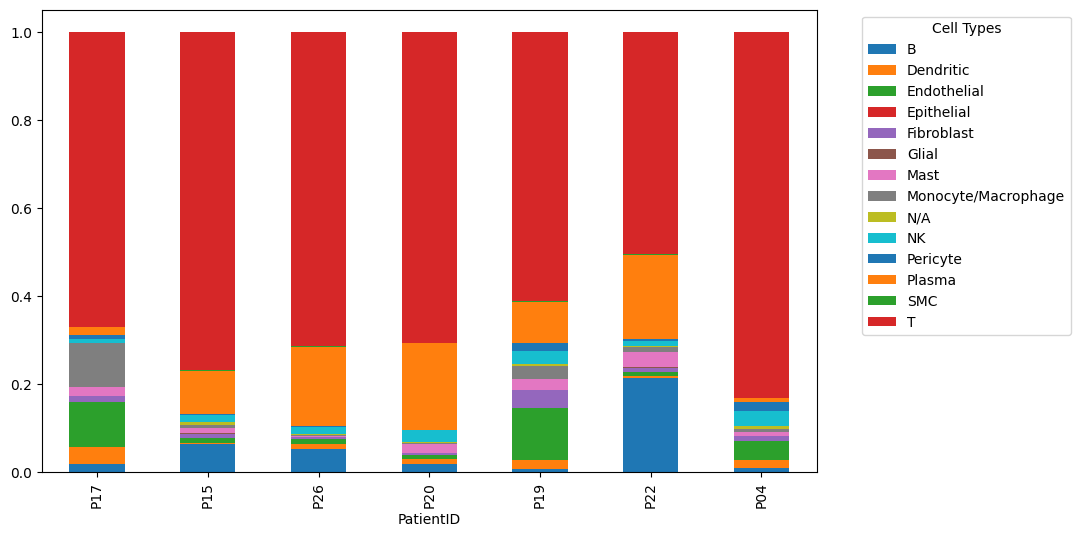

In [200]:
# Plot
pivot_df.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    # colormap='Paired', 
    legend=True, 
)

# Move legend to the right side
plt.legend(
    title='Cell Types', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left'
)

In [205]:
adata_chen_T_NK = adata_chen[(adata_chen.obs['Manual_CellType_lvl_1'].isin(['T', 'NK'])) & 
                             (adata_chen.obs['BiopsySite'].isin(['Tumor']))].copy()

In [226]:
import glob 
joanito_table2 = pd.read_csv(glob.glob(f'/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/Table2.*.csv')[0])
joanito_table3 = pd.read_csv(glob.glob(f'/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/Table3.*.csv')[0])
joanito_table4 = pd.read_csv(glob.glob(f'/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/Table4.*.csv')[0])
joanito_table5 = pd.read_csv(glob.glob(f'/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/Table5.*.csv')[0])
joanito_table6 = pd.read_csv(glob.glob(f'/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/Table6.*.csv')[0])
joanito_table7 = pd.read_csv(glob.glob(f'/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/Table7.*.csv')[0])
joanito_table8 = pd.read_csv(glob.glob(f'/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/Table8.*.csv')[0])
joanito_table9 = pd.read_csv(glob.glob(f'/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/Table9.*.csv')[0])

In [246]:
pos_reg_T_activation = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/GO/T/pos_reg_T_activation_hallmarks', sep='\t')
neg_reg_T_activation = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/GO/T/neg_reg_T_activation_hallmarks', sep='\t')
pos_reg_T_activation['gene'] = [ list(tup)[1].upper() for tup in pos_reg_T_activation.itertuples() ]
neg_reg_T_activation['gene'] = [ list(tup)[1].upper() for tup in neg_reg_T_activation.itertuples() ]

In [247]:
sc.tl.score_genes( adata_chen, pos_reg_T_activation['gene'], score_name='pos_T_act' )
sc.tl.score_genes( adata_chen, neg_reg_T_activation['gene'], score_name='neg_T_act' )

       'CD209C', 'CD209D', 'CD209E', 'CD244A', 'CYRIB', 'EPO', 'FLT3L',
       'GIMAP3', 'H2-AA', 'H2-AB1', 'H2-DMA', 'H2-DMB1', 'H2-DMB2', 'H2-EA',
       'H2-EB1', 'H2-EB2', 'H2-M3', 'H2-OA', 'H2-OB', 'H2-T23', 'H60A',
       'ICOSL', 'IGHG2A', 'IL4I1B', 'IL4RA', 'IRGM1', 'KITL', 'LILRB4A',
       'LILRB4B', 'MIR326', 'PAGR1A', 'RAET1B', 'SKINT1', 'TCRB', 'TRP53BP1',
       'ZFP335', 'ZFP609'],
      dtype='object')
       'IL4RA', 'LILRB4A', 'LILRB4B', 'MARCHF7', 'SKINT2', 'SLFN1', 'ZFP35',
       'ZFP608'],
      dtype='object')


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


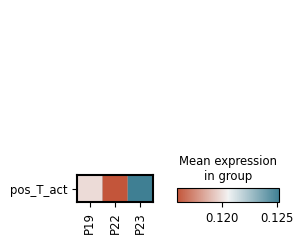

In [264]:
var_names_e={ 
             # 'Cellular stress response' : ['TXNIP', 'OAS1', 'CAPN8', 'PPP1R13L', 'VNN1'],
             'Response to bacteria' : ['CD55', 'CTSS', 'SPINK1',],
             'Mucosal protection' : ['TFF1', 'TFF3', 'MUC1', 'REG4', 'SPINK4',], 
            }

sc.pl.matrixplot(adata_chen[(adata_chen.obs['Manual_CellType_lvl_2']=='CD8+ T') & (adata_chen.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_TC ))], 
                 var_names=['pos_T_act', ],
                 groupby='PatientID', 
                 categories_order=chen_patient_order_by_MSI_intensity_TC, 
                 # standard_scale='var',
                cmap=sns.diverging_palette(20, 220, as_cmap=True),
                    swap_axes=True,
                 )

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


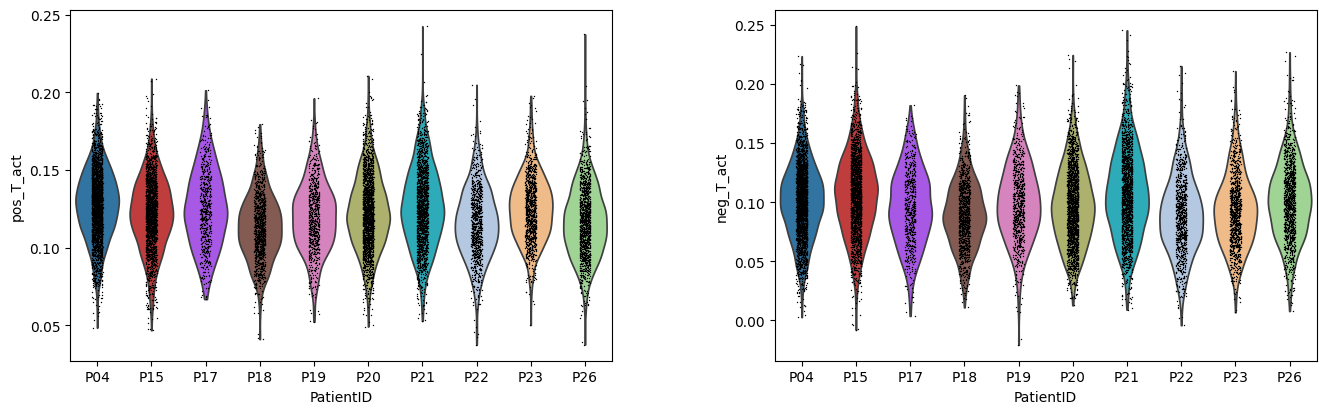

In [253]:
sc.pl.sta(adata_chen[adata_chen.obs['Manual_CellType_lvl_2']=='CD8+ T'], 
                 keys=['pos_T_act', 'neg_T_act'],
                 groupby='PatientID', 
                 # categories_order=chen_patient_order_by_MSI_intensity, 
                 # standard_scale='var',
                cmap=sns.diverging_palette(20, 220, as_cmap=True),
                   # swap_axes=True,
                 )

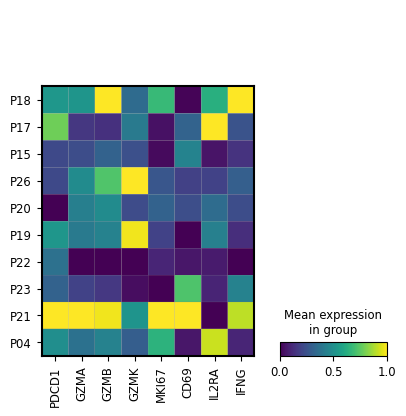

In [224]:
sc.pl.matrixplot(adata_chen_T_NK, var_names=['PDCD1', 'GZMA', 'GZMB', 'GZMK', 'MKI67', 'CD69', 'IL2RA', 'IFNG'], groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity, standard_scale='var')

<Axes: xlabel='PatientID', ylabel='count'>

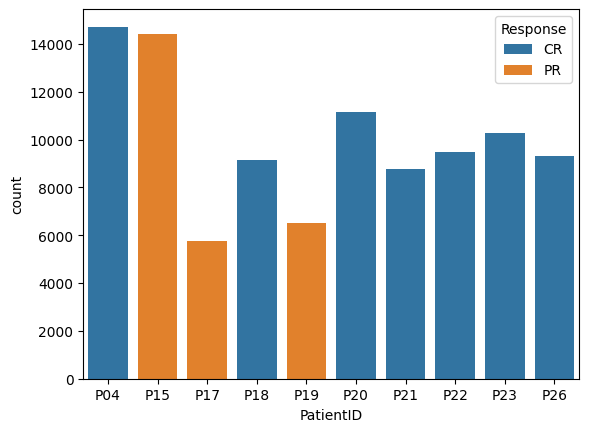

In [215]:
sns.countplot(data=adata_chen.obs, x='PatientID', hue='Response')

In [214]:
sns.barplot(data=CellTypeProportion[(CellTypeProportion['Manual_CellType_lvl_2']=='Macrophage') & (CellTypeProportion['BiopsySite']=='Tumor')], 
            x='PatientID', y='CellProportion', order=chen_patient_order_by_MSI_intensity)

KeyError: 'Manual_CellType_lvl_2'

In [73]:
adata_chen = adata_chen.raw.to_adata()

In [77]:
sc.pp.normalize_total(adata_chen)
sc.pp.log1p(adata_chen)

In [119]:
sc.tl.score_genes(adata_chen, gene_list=['B2M',], score_name='AP_score')

In [90]:
adata_chen.obs['APxMSI'] = adata_chen.obs['AP_score']*adata_chen.obs['AvgSTRDiff']

In [115]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)

dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_chen.obs['PatientID'] ]

<Axes: xlabel='AP_score', ylabel='PatientID'>

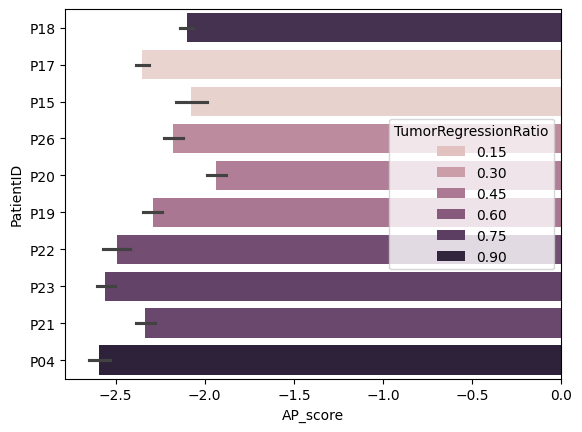

In [122]:
sns.barplot(data=adata_chen.obs[~(adata_chen.obs['Manual_CellType_lvl_1'].isin(['N/A', 'Epithelial'])) & 
                                (adata_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial')], 
            y='PatientID', x='AP_score', 
            order=chen_patient_order_by_MSI_intensity, 
            hue='TumorRegressionRatio')

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


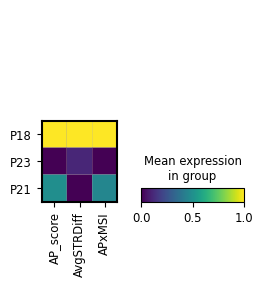

In [123]:
sc.pl.matrixplot(adata_chen[(adata_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial') & (adata_chen.obs['PatientID'].isin(['P18', 'P23', 'P21']))], 
              var_names=['AP_score', 'AvgSTRDiff', 'APxMSI'], 
              groupby='PatientID', standard_scale='var',
              #categories_order=chen_patient_order_by_MSI_intensity
              categories_order=['P18', 'P23', 'P21']
              )

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


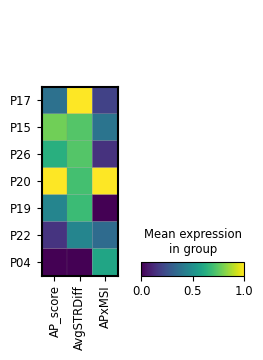

In [124]:
sc.pl.matrixplot(adata_chen[(adata_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial') & (adata_chen.obs['PatientID'].isin(['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P04']))], 
              var_names=['AP_score', 'AvgSTRDiff', 'APxMSI'], 
              groupby='PatientID', standard_scale='var',
              #categories_order=chen_patient_order_by_MSI_intensity
              categories_order=['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P04']
              )